In [155]:
import os

import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math
from scipy.stats import unitary_group
import scipy as scp

from stable_baselines3 import PPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps

In [169]:
H = np.array([[1,1],[1,-1]])/np.sqrt(2)
q_zero = np.array([[1],[0]])
qubit_plus = H@q_zero
sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])

def brownian_circuit(dim, n, dt):
    u = np.eye(dim)
    for j in range(n):
        re = np.random.normal(size=(dim,dim))
        im = 1j*np.random.normal(size=(dim,dim))
        c = re + im
        h = (c+np.conj(c.T))/4
        u = u@scp.linalg.expm(1j*h*dt)
    return u

def randomUnitary_closetoid(dim, t, n):
    return brownian_circuit(dim,n, np.sqrt(1/(n*dim))*2*np.pi*t)

def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Steps')
    plt.ylabel('Average Fidelity')
    plt.title(title + " Smoothed")
    plt.show()
    
def u3(theta, phi, lamb):
    return np.array([[np.cos(theta/2), -np.exp(1j*lamb)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(theta+lamb))*np.cos(theta/2) ]])

def rx(theta):
    return u3(theta, -np.pi/2, np.pi/2)

def ry(theta):
    return u3(theta, 0.0,0.0)

def cost_fun(U,V):
    return np.sum(np.sum(np.abs(U-V)))

def ux(theta):
    return scp.linalg.expm(-1j*theta*sx/2)

def uz(theta):
    return scp.linalg.expm(-1j*theta*sz/2)

def eu_dec(theta, phi, lamb,phase):
    return (np.exp(1j*phase))*ux(theta)@uz(phi)@ux(lamb)

In [323]:
class measurement_env(gym.Env):
    metadata = {'render.modes': ['human']}
    
    q_zero = np.array([[1],[0]])
    H = np.array([[1,1],[1,-1]])/np.sqrt(2)
    qubit_plus = H@q_zero
    sx = np.array([[0,1],[1,0]])
    sz = np.array([[1,0],[0,-1]])
    
    def __init__(self, n_qubits, unitary, noise=0, noise_type="random" ,test_fidelity=False, init_state_random = True, init_random_unitary= np.eye(2)):
        self.n_qubits = n_qubits
        self.unitary = unitary
        self.noise = noise
        self.noise_type = noise_type
        self.test_fidelity = test_fidelity
        self.init_state_random = init_state_random
        
        self.action_space = spaces.Box(low = np.array([-1*(np.pi+0.1)]), high=np.array([1*(np.pi+0.1)]) )
        self.observation_space = spaces.Box(low=-4*np.ones(self.n_qubits), high=1*(np.pi+0.1)*np.ones(self.n_qubits))
        
        
        self.state = -4*np.ones(self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        self.init_rand = init_random_unitary
        
        if self.init_state_random:
            st = unitary_group.rvs(2)@q_zero
        elif not self.init_state_random:
            st = self.init_rand@q_zero
        
        if self.noise_type=="random":
            noisyU = randomUnitary_closetoid(2,self.noise,20)
            self.final_qstate_train = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
        elif self.noise_type=="bitflip":
            errs = np.random.choice([0,1],p=[1-self.noise, self.noise])
            if errs==0:
                self.final_qstate_train = self.pure2density(self.unitary@st)
            elif errs==1:
                self.final_qstate_train = self.pure2density(sx@self.unitary@st)
            
        self.final_qstate_test = self.pure2density(self.unitary@st)

        
        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
        
        self.s_even = 0
        self.s_odd = 0

    def step(self, action):
        current_measurement = self.total_measurements - self.measurements_left
        self.state[current_measurement] = action[0]
        corrected_action = action[0]
        if current_measurement%2==0:
            corrected_action =(corrected_action*((-1)**(self.s_even%2)))
        elif current_measurement%2==1:
            corrected_action =(corrected_action*((-1)**(self.s_odd%2)))
        
        self.qstate, outcome = self.measure_angle(self.qstate, corrected_action,current_measurement)
        
        if current_measurement%2==0:
            self.s_odd += int(outcome)
        elif current_measurement%2==1:
            self.s_even += int(outcome)
        
        reward = 0 #fidelity
        
        self.measurements_left -= 1
        if self.measurements_left == 0:
            sx = np.array([[0,1],[1,0]])
            sz = np.array([[1,0],[0,-1]])
            last_qbit = self.partial_trace(self.qstate,[i for i in range(0,self.n_qubits)])
            ssx =int(self.s_even%2)
            ssz =int(self.s_odd%2)
            byprod = np.linalg.matrix_power(sx,ssx)@np.linalg.matrix_power(sz,ssz)
            last_qbit = byprod@last_qbit@(np.conjugate(byprod.T))
            if not self.test_fidelity:
                reward = self.fidelity(last_qbit, self.final_qstate_train)
            elif self.test_fidelity:
                reward = self.fidelity(last_qbit, self.final_qstate_test)
            done = True
        else:
            done = False
        
        info = {}

        return self.state, reward, done, info
        
        
    def reset(self):
        
        self.state = -4*np.ones(self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        if self.init_state_random:
            st = unitary_group.rvs(2)@q_zero
        elif not self.init_state_random:
            st = self.init_rand@q_zero
        
        if self.noise_type=="random":
            noisyU = randomUnitary_closetoid(2,self.noise,20)
            self.final_qstate_train = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
        elif self.noise_type=="bitflip":
            errs = np.random.choice([0,1],p=[1-self.noise, self.noise])
            if errs==0:
                self.final_qstate_train = self.pure2density(self.unitary@st)
            elif errs==1:
                self.final_qstate_train = self.pure2density(sx@self.unitary@st)
                
        self.final_qstate_test = self.pure2density(self.unitary@st)

        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
        
        self.s_even = 0
        self.s_odd = 0
          
        return self.state
        
    def render(self, mode='human', close=False):
        pass

    def controlled_z(self, i, j , n):
        op1, op2 = 1, 2
        for k in range(1,n+1):
            op1 = np.kron(op1, np.eye(2))
            if k in [i,j]:
                op2 = np.kron(op2, np.kron(np.conjugate(np.array([[0],[1]]).T), np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
        return op1-op2


    def create_1D_gs(self, n):
        psi = 1
        for i in range(1,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi

    def create_1D_gs_input(self, psi, n):
        for i in range(2,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi    

    def fidelity(self, sigma, rho):
        srho = linalg.sqrtm(rho)
        prod = srho@sigma@srho
        sprod = linalg.sqrtm(prod)
        return np.abs(np.trace(sprod))

    def pure2density(self, psi):
        return np.kron(psi, np.conjugate(psi.T))

    def measure_angle(self, rho, angle, i):
        n = self.n_qubits+1
        pi0 = 1
        pi1 = 1
        pi0op = np.array([[1, np.exp(-angle*1j)],[np.exp(angle*1j), 1]])/2
        pi1op = np.array([[1,-np.exp(-angle*1j)],[-np.exp(angle*1j), 1]])/2
        for k in range(0,n):
            if k == i:
                pi0 = np.kron(pi0, pi0op)
                pi1 = np.kron(pi1, pi1op)
            else:
                pi0 = np.kron(pi0, np.eye(2))
                pi1 = np.kron(pi1, np.eye(2))
        prob0, prob1 = np.real(np.trace(rho@pi0)), np.real(np.trace(rho@pi1))
        measurement = np.random.choice([0,1], p=[prob0,prob1]/(prob0+prob1))

        if measurement==0:
            rho = pi0@rho@pi0/prob0
        elif measurement==1:
            rho = pi1@rho@pi1/prob1
        
        return rho, measurement

    def partial_trace(self, rho, indices):
        x,y = rho.shape
        n = int(math.log(x,2))
        r = len(indices)
        sigma = np.zeros((int(x/(2**r)), int(y/(2**r))))
        for m in range(0, 2**r):
            qubits = format(m,'0'+f'{r}'+'b')
            ptrace = 1
            for k in range(0,n):
                if k in indices:
                    idx = indices.index(k)
                    if qubits[idx]=='0':
                        ptrace = np.kron(ptrace, np.array([[1],[0]]))
                    elif qubits[idx]=='1':
                        ptrace = np.kron(ptrace, np.array([[0],[1]]))
                else:
                    ptrace = np.kron(ptrace, np.eye(2))
            sigma = sigma + np.conjugate(ptrace.T)@rho@(ptrace)
        return sigma

In [151]:
env = measurement_env(4,H, noise=0, test_fidelity=False)

log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [152]:
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=int(5e4), callback=event_callback)

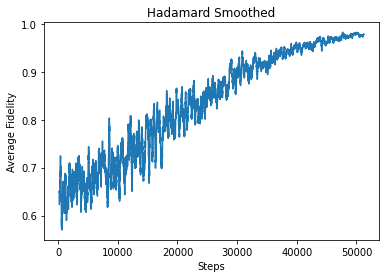

In [153]:
plot_results(log_dir, title="Hadamard")


# Fidelity vs noise (t)


In [72]:
dats2 = []
for ruid in np.linspace(0,0.5,5):
    env = measurement_env(4,H, noise=ruid, test_fidelity=False)

    log_dir = "./logs/"
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
    event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=int(5e4), callback=event_callback)
    
    vals = np.array([])
    env = measurement_env(4,H, noise=ruid, test_fidelity=True)
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            if done:
                vals = np.append(vals, [reward])
    env.close()
        
    dats2.append(vals)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


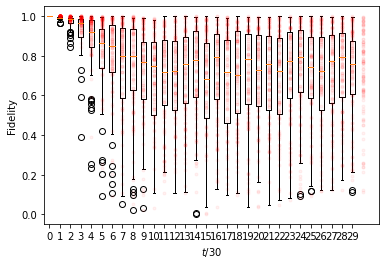

In [112]:
plt.boxplot(dats, positions=range(30))
plt.xlabel(r"$t/30$")
plt.ylabel("Fidelity")
for i in range(30):
    y = dats[i]
    x = len(y)*[i+1]
    plt.plot(x, y, 'r.', alpha=0.05)
plt.show()

100


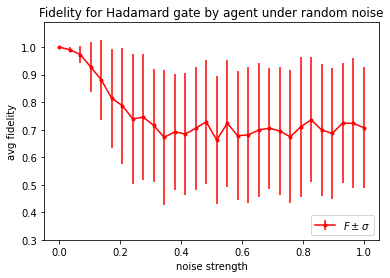

In [276]:
dd = []
sigm = []
print(len(dats[0]))
for (indx,i) in enumerate(range(len(dats))):
    dd.append(np.mean(dats[indx]))
    sigm.append(np.std(dats[indx]))

plt.errorbar(np.linspace(0,1,30), dd, yerr= sigm, c='r', marker='.', label=r"$F \pm \sigma$")
plt.legend(loc=4)
plt.xlabel("noise strength")
plt.ylabel("avg fidelity")
plt.ylim(0.3,1.09)
plt.title("Fidelity for Hadamard gate by agent under random noise")
plt.show()

In [264]:
dats2 = []
for ruid in np.linspace(0,1,30):
    env = measurement_env(4,H, noise=ruid, noise_type="bitflip", test_fidelity=False)

    log_dir = "./logs/"
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
    event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=int(5e4), callback=event_callback)
    
    vals = np.array([])
    env = measurement_env(4,H, noise=ruid, test_fidelity=True)
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            if done:
                vals = np.append(vals, [reward])
    env.close()
        
    dats2.append(vals)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Learning with noisy data, tested with no noise


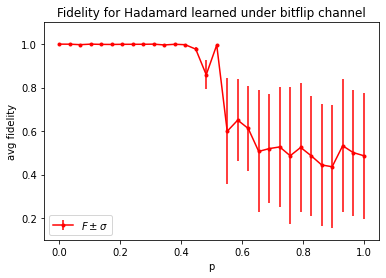

In [278]:
dd = []
sigm = []
print("Learning with noisy data, tested with no noise")
for (indx,i) in enumerate(range(len(dats2))):
    dd.append(np.mean(dats2[indx]))
    sigm.append(np.std(dats2[indx]))

plt.errorbar(np.linspace(0,1,30), dd, yerr= sigm, c='r', marker='.', label=r"$F \pm \sigma$")
plt.legend(loc=3)
plt.xlabel("p")
plt.ylabel("avg fidelity")
plt.ylim(0.1,1.1)
plt.title("Fidelity for Hadamard learned under bitflip channel")
plt.show()


--------------------------------------------

# Hessian of fidelity

--------------------------------------------

In [166]:
import numdifftools as nd

## 4 parameters

In [353]:
# we need to fix input state (we pick |0>) to have a deterministic Hessian
initR = unitary_group.rvs(2)
def fid_fun(angles, gate):
    env = measurement_env(4, gate, noise=0, test_fidelity=True, init_state_random=False, init_random_unitary=initR)
    fids = []
    for k in range(1):
        obs = env.reset()
        done,i = False, 0
        while not done:
            obs, reward, done, info = env.step([angles[i]])
            i+=1
            if done:
                fids.append(reward)
    env.close()
    return np.mean(fids)

def hess(gate, p): return nd.Hessian(lambda angles: fid_fun(angles, gate) )(p)

In [354]:
HessMatrix = hess(H, [-np.pi/4 ,-np.pi/2, -np.pi/2, -np.pi/4 ]).round(5);
eigVals, eigVecs = np.linalg.eig(HessMatrix)

In [355]:
for i in range(4):
    print(f"{eigVecs[:,i]} has eigValue {eigVals[i]}")

[-0.63313998  0.41166701  0.16969914 -0.63313998] has eigValue -0.41727133529259297
[ 1.29960928e-05 -3.81078910e-01  9.24542516e-01  1.29960928e-05] has eigValue -0.24999856928216113
[ 7.07106781e-01 -2.05809164e-10 -8.48284033e-11 -7.07106781e-01] has eigValue -3.87480383328502e-17
[0.31485514 0.827834   0.34120864 0.31485514] has eigValue -9.542524614832006e-08


In [327]:
hess(H, [0 ,-np.pi/2, -np.pi/2, -np.pi/2 ]).round(5)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


array([[-0.19407,  0.09169, -0.04948, -0.19407],
       [ 0.09169, -0.0997 , -0.0811 ,  0.09169],
       [-0.04948, -0.0811 , -0.20624, -0.04948],
       [-0.19407,  0.09169, -0.04948, -0.19407]])

In [328]:
#check that there is a one-parametric family of solutions to implement H
for t in np.linspace(0,5,10):
    print(fid_fun([-np.pi/2 + t,-np.pi/2, -np.pi/2, -t], H))

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


1.0000000058333698
1.0000000047123403
1.0000000024911326
1.0000000005509433
1.0000000016830797
1.0000000048167585
1.0000000027963578
1.0000000048167585
1.0000000037586558
1.0000000046502258


## 3 parameters

In [377]:
initR = unitary_group.rvs(2)
# initR = np.eye(2)
# initR = np.array([[0,1],[1,0]])
# initR = H
def fid_fun2(angles, gate):
    env = measurement_env(4, gate, noise=0, test_fidelity=True, init_state_random=False, init_random_unitary=initR)
    fids = []
    angles= np.append([0],angles)
    for k in range(1):
        obs = env.reset()
        done,i = False, 0
        while not done:
            obs, reward, done, info = env.step([angles[i]])
            i+=1
            if done:
                fids.append(reward)
    env.close()
    return np.mean(fids)

def hess2(gate, p): return nd.Hessian(lambda angles: fid_fun2(angles, gate) )(p)

In [378]:
HessMatrix2 = hess2(H, [-np.pi/2, -np.pi/2, -np.pi/2 ]).round(5)

In [379]:
eigVals2, eigVecs2 = np.linalg.eig(HessMatrix2)
for i in range(3):
    print(f"{eigVecs2[:,i]} has eigValue {eigVals2[i]}")

[ 0.88756401 -0.37459831 -0.26815339] has eigValue -2.7132644876044507e-06
[0.44823729 0.83660128 0.31493117] has eigValue -0.25000189921574384
[-0.10636479  0.39971791 -0.91044611] has eigValue -0.24999538751976855


In [380]:
hess2(H, [-np.pi/2 , -np.pi/2, -np.pi/2 ]).round(5)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


array([[-0.05306, -0.08312, -0.0595 ],
       [-0.08312, -0.21492,  0.02511],
       [-0.0595 ,  0.02511, -0.23202]])

In [381]:
fid_fun2(np.array([-np.pi/2 + 5, -np.pi/2, -np.pi/2 ]),H )

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


0.9612433612765581

In [394]:
fid_fun2(np.array([-np.pi/2, -np.pi/2, -np.pi/2 ]) + 0.5*np.array([ 0.88756401, -0.37459831, -0.26815339]),H )

0.9996745474921975

# 2D cluster-state (to do)

In [116]:
import networkx as nx

In [119]:
def graph_state(self, G):
    n = G.number_of_nodes()
    psi = 1
    for i in range(n):
        psi = np.tensor(psi, qubit_plus)
    for j in list(G.edges()):
        psi = controlled_z(j[0],j[1], n)@psi
    return psi
    
def graph_with_multiple_inputs(self, G, inputs=[], indices=[]):
    n = G.number_of_nodes()
    psi = 1
    if len(inputs)==0:
        psi = graph_state(G)
    else:
        for i in range(n):
            if (indx, j) in enumerate(indices):
                psi = np.tensor(psi, inputs[indx])
            else:
                psi = qubit_plus
    
    for j in list(G.edges()):
        psi = controlled_z(j[0],j[1], n)@psi
        
    return psi   

def cz_after_layer_measurement(rho, n):
    if n>1:
        for i in range(n-1):
            controll = controlled_z(i, i+1, n)
            rho = controll*rho*(np.conj(controll.T))
    return rho

def swap_ij(i,j,n):
    op1,op2,op3,op4 = np.ones(4)
    for k in range(n):
        if k==i or k==j:
            op1 = np.tensor(op1,np.tensor(np.array([1,0]).T, np.array([1,0])))
            op4 = np.tensor(op4,np.tensor(np.array([0,1]).T, np.array([0,1])))
        else:
            op1 = np.tensor(op1, np.eye(2))
            op4 = np.tensor(op4, np.eye(2))
        
        if k == i:
            op2 = np.tensor(op2,np.tensor(np.array([1,0]).T, np.array([0,1])))
            op3 = np.tensor(op3,np.tensor(np.array([0,1]).T, np.array([1,0])))
        elif k==j:
            op2 = np.tensor(op2,np.tensor(np.array([0,1]).T, np.array([1,0])))
            op3 = np.tensor(op3,np.tensor(np.array([1,0]).T, np.array([0,1])))
        else:
            op2 = np.tensor(op2, np.eye(2))
            op3 = np.tensor(op3, np.eye(2))
    return op1+op2+op3+op4

def measure_angle(self, rho, angle, i):
    n = self.n_qubits+1
    pi0 = 1
    pi1 = 1
    pi0op = np.array([[1, np.exp(-angle*1j)],[np.exp(angle*1j), 1]])/2
    pi1op = np.array([[1,-np.exp(-angle*1j)],[-np.exp(angle*1j), 1]])/2
    for k in range(0,n):
        if k == i:
            pi0 = np.kron(pi0, pi0op)
            pi1 = np.kron(pi1, pi1op)
        else:
            pi0 = np.kron(pi0, np.eye(2))
            pi1 = np.kron(pi1, np.eye(2))
    prob0, prob1 = np.real(np.trace(rho@pi0)), np.real(np.trace(rho@pi1))
    measurement = np.random.choice([0,1], p=[prob0,prob1]/(prob0+prob1))

    if measurement==0:
        rho = pi0@rho@pi0/prob0
    elif measurement==1:
        rho = pi1@rho@pi1/prob1

    return rho, measurement

def partial_trace(self, rho, indices):
        x,y = rho.shape
        n = int(math.log(x,2))
        r = len(indices)
        sigma = np.zeros((int(x/(2**r)), int(y/(2**r))))
        for m in range(0, 2**r):
            qubits = format(m,'0'+f'{r}'+'b')
            ptrace = 1
            for k in range(0,n):
                if k in indices:
                    idx = indices.index(k)
                    if qubits[idx]=='0':
                        ptrace = np.kron(ptrace, np.array([[1],[0]]))
                    elif qubits[idx]=='1':
                        ptrace = np.kron(ptrace, np.array([[0],[1]]))
                else:
                    ptrace = np.kron(ptrace, np.eye(2))
            sigma = sigma + np.conjugate(ptrace.T)@rho@(ptrace)
        return sigma

def arbitrary_qubit_gate(u,i,n):
    op = 1
    for k in range(n):
        if k==i:
            op = np.tensor(op, u)
        else:
            op = np.tensor(op, np.eye(2))
    return op
    
def measure_angle_2d_intermediate(rho, angle, i, n, fix=True):
    rho = np.tensor(rho, qubit_plus)
    controll_ilast = controlled_z(i, n, n+1)
    rho = controll_ilast*rho*(np.conj(controll_ilast.T))
    rho, outcome = measure_angle(rho, angle, i)
    swap_ilast = swap_ij(i, n,n+1)
    rho = swap_ilast*rho*(np.conj(swap_ilast.T))
    rho = partial_trace(rho, [n])
    
    if fix and outcome==1:
        rho = arbitrary_qubit_gate(X,i,n)@rho@np.conj(arbitrary_qubit_gate(X,i,n).T)
    return rho, outcome
    
def layer_measurement(rho, angle, i, n, last_layer, fix=True):
    if not last_layer:
        rho, outcome = measure_angle_2d_intermediate(rho, angle, i, n, fix=fix)
    elif last_layer:
        rho, outcome = measure_angle(rho, angle, i)
    if fix and i<n:
        if i+1==n-1:
            pass
        ## LEARN HOW TO FIX AFTER SOME NONCLIFFORD MEASUREMENT!!
        
def cnot_ij(i,j,n):
    op1,op2,op3,op4 = np.ones(4)
    for k in range(n):
        if k==i or k==j:
            op1 = np.tensor(op1,np.tensor(np.array([1,0]).T, np.array([1,0])))
        else:
            op1 = np.tensor(op1, np.eye(2))        
        if k == i:
            op2 = np.tensor(op2,np.tensor(np.array([1,0]).T, np.array([1,0])))
            op3 = np.tensor(op3,np.tensor(np.array([0,1]).T, np.array([0,1])))
            op4 = np.tensor(op4,np.tensor(np.array([0,1]).T, np.array([0,1])))
        elif k==j:
            op2 = np.tensor(op2,np.tensor(np.array([0,1]).T, np.array([0,1])))
            op3 = np.tensor(op3,np.tensor(np.array([1,0]).T, np.array([0,1])))
            op4 = np.tensor(op4,np.tensor(np.array([0,1]).T, np.array([1,0])))
        else:
            op2 = np.tensor(op2, np.eye(2))
            op3 = np.tensor(op3, np.eye(2))
            op4 = np.tensor(op4, np.eye(2))
            
    return op1+op2+op3+op4